In [1]:
import sys
import os

if "/Users/shvimas/GitHub/diploma/src" not in sys.path:
    sys.path.append("/Users/shvimas/GitHub/diploma/src")
    
os.chdir("/Users/shvimas/GitHub/diploma")

In [2]:
%matplotlib inline
import matplotlib.pyplot as pl
import helper_funcs as hf
import data_helpers as dh
import compare_models as cmp
import numpy as np
import pandas as pd
import itertools as it
import forecast as fc
from importlib import reload
from config import root_dir


pl.style.use('ggplot')
pl.rcParams["figure.figsize"] = (15, 10)   

/Users/shvimas/miniconda3/envs/default/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
pl.rcParams["figure.figsize"] = (15, 10)

img_dir = root_dir + '/paper/img/'

def save_picture(name: str):
    pl.savefig(f'{img_dir}/{name}.png', dpi=250)    

In [4]:
scores_per_dot = cmp.get_scores()   
metric = "RMSE"

In [5]:
bad_metric = {
    'he with vg': 2,
    'he with ls': 3,
    'vg with he': 1.5,
    'vg with ls': 4.0,
    'ls with he': 5,
    'ls with vg': 5
}

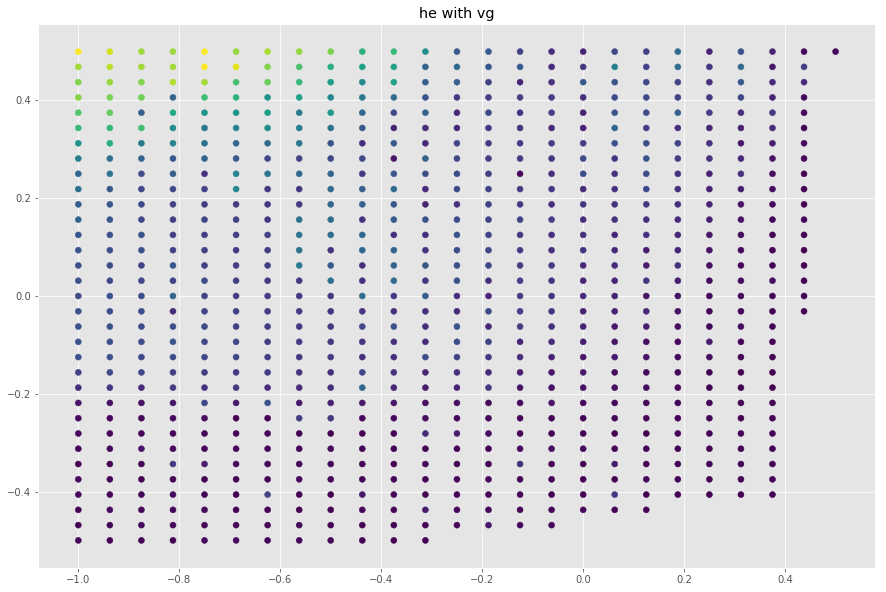

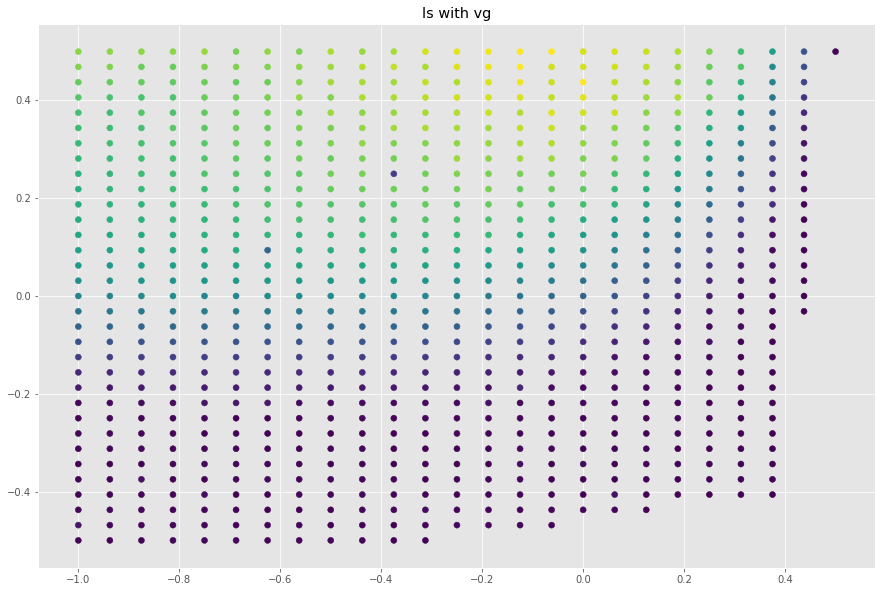

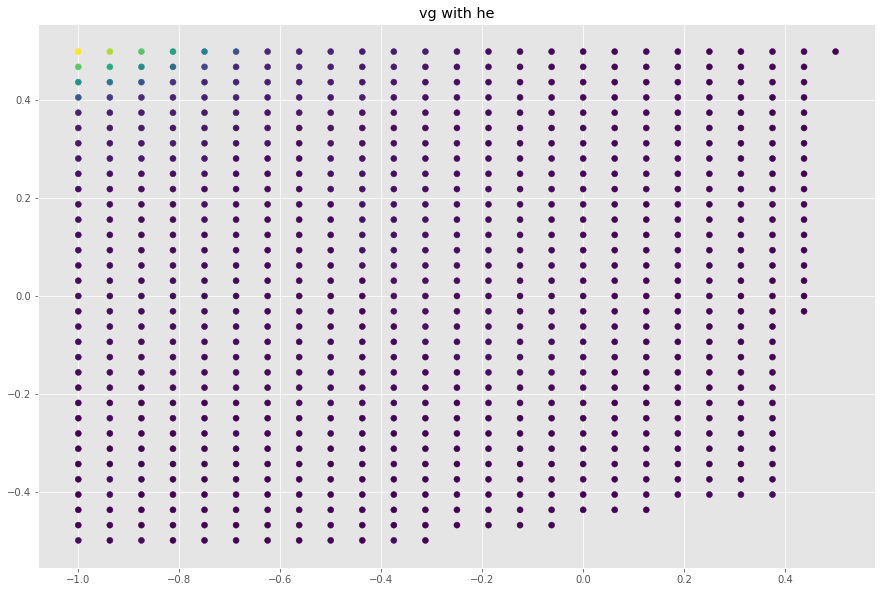

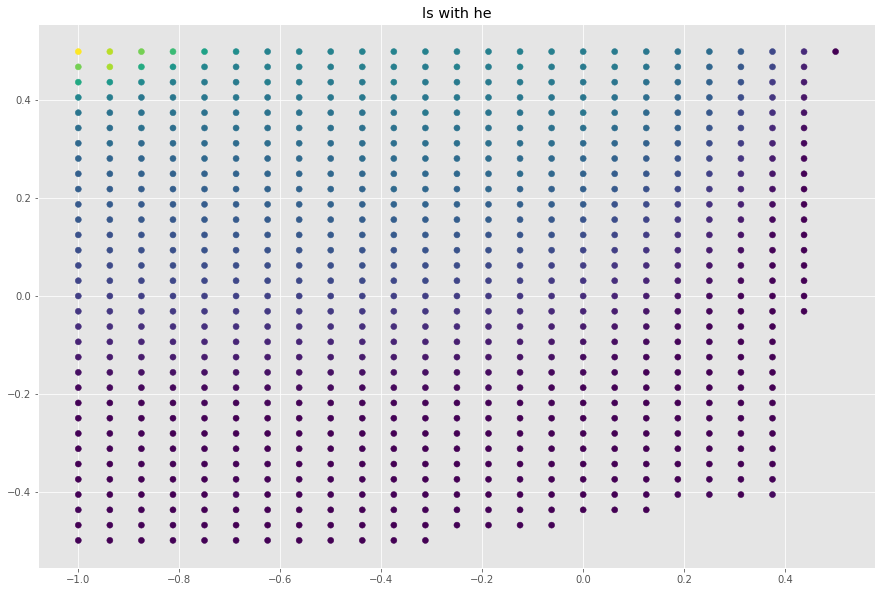

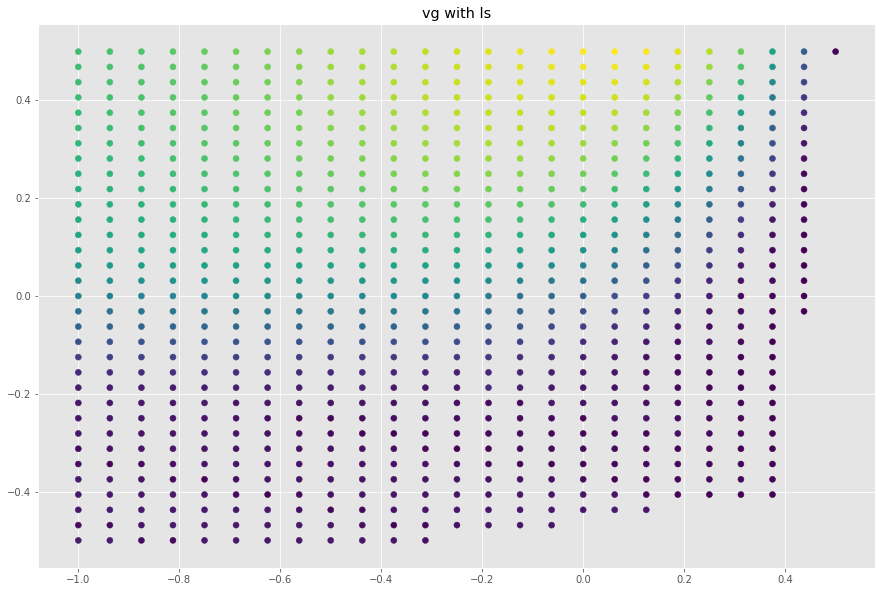

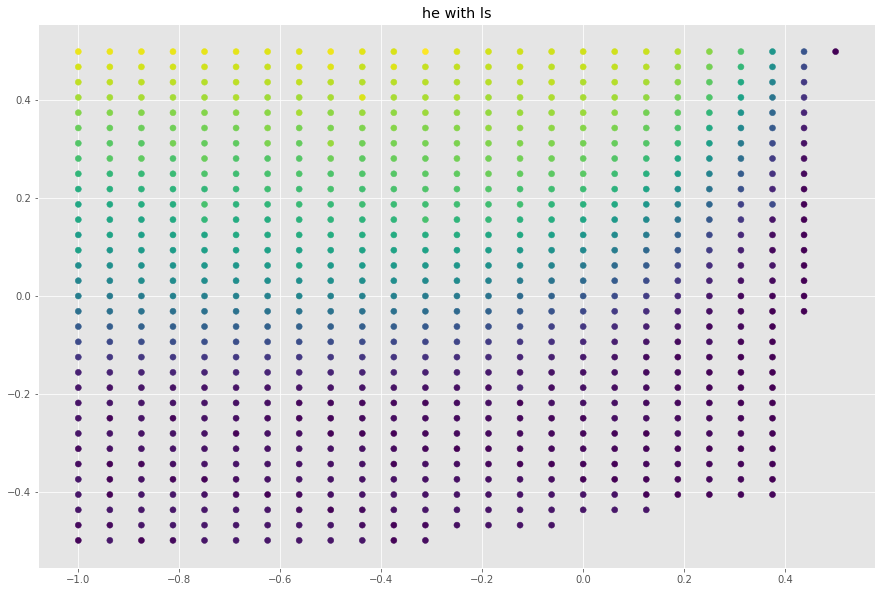

In [9]:
vg_dots = cmp.vg_initial_dots
bounds, factors, means = hf.get_pca_data('vg')
dots_2d = (vg_dots - means) @ factors.transpose()
global_scores = {
    'he': np.zeros(len(dots_2d)), 
    'vg': np.zeros(len(dots_2d)), 
    'ls': np.zeros(len(dots_2d))
}
sum_scores = np.zeros(len(dots_2d))


for model1, model2 in it.permutations(cmp.models, 2):
    name = f"{model2} with {model1}"
    scores = list(map(lambda el: el[1][name], scores_per_dot))
    global_scores[model2] += scores
    sum_scores += scores

    df = pd.DataFrame(dots_2d, columns=['x', 'y'], )
    df['score'] = scores

    df = df[df.score < bad_metric[name]]

    pl.title(name)
    pl.scatter(df['x'], df['y'], c=df['score'])
    pl.show()

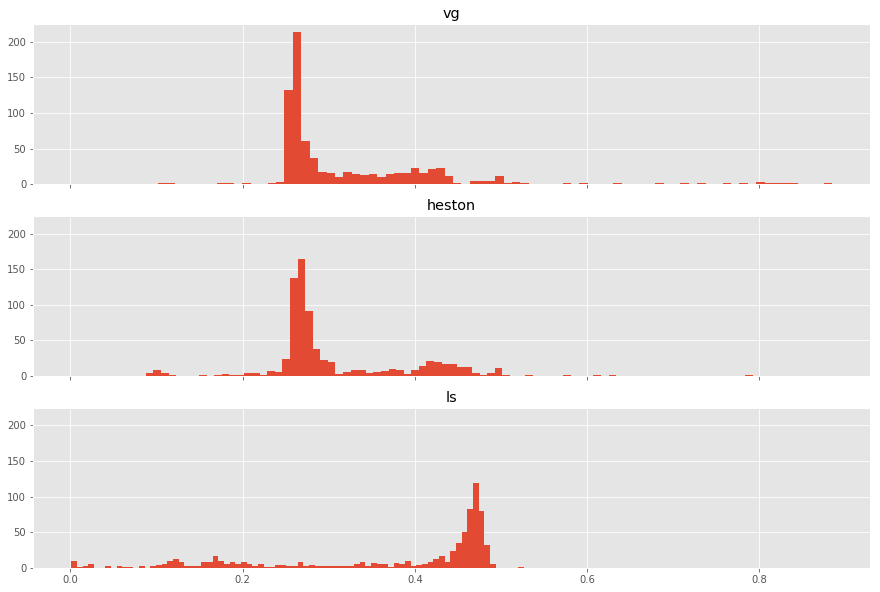

In [10]:
f, axarr = pl.subplots(3, 1, sharex='col', sharey='col')
i = 0
for model in cmp.models:
    score = global_scores[model] / sum_scores
    axarr[i].hist(score, label=model, bins=80)
    axarr[i].set_title(model if model != 'he' else 'heston')
    i += 1

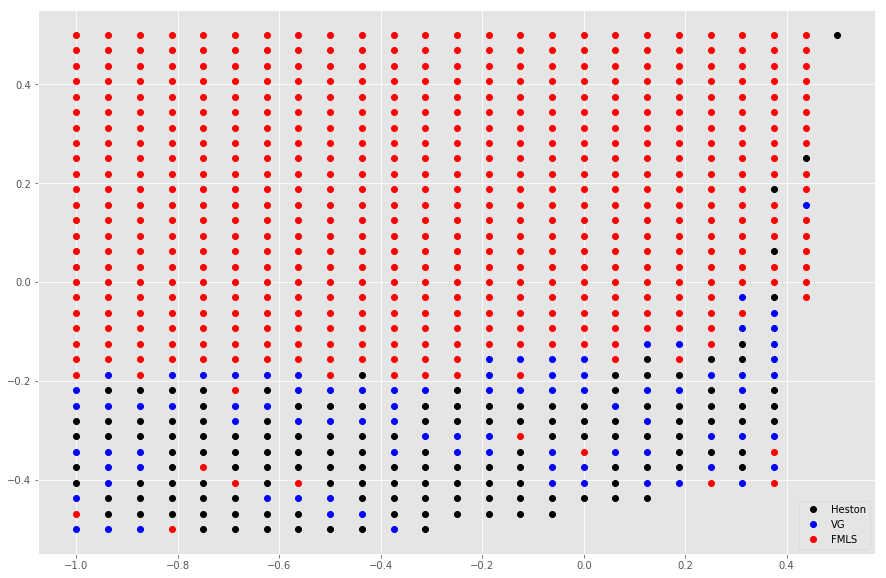

In [11]:
colors = dict(he='k', Heston='k', vg='b', VG='b', ls='r', FMLS='r')

score_he = global_scores['he'] / sum_scores
score_vg = global_scores['vg'] / sum_scores
score_ls = global_scores['ls'] / sum_scores
max_score = np.array(list(map(lambda x: max(*x), list(zip(score_he, score_vg, score_ls)))))

for model in ['he', 'vg', 'ls']:
    first_time = True
    score = global_scores[model] / sum_scores
    df = pd.DataFrame(dots_2d, columns=['x', 'y'])
    for inx, row in df.iterrows():
        if score[inx] == max_score[inx]:
            if first_time:
                pl.plot(row.x, row.y, f'{colors[model]}o', label=hf.title(model))
            else:
                pl.plot(row.x, row.y, f'{colors[model]}o')
            first_time = False
            
pl.legend()
pass

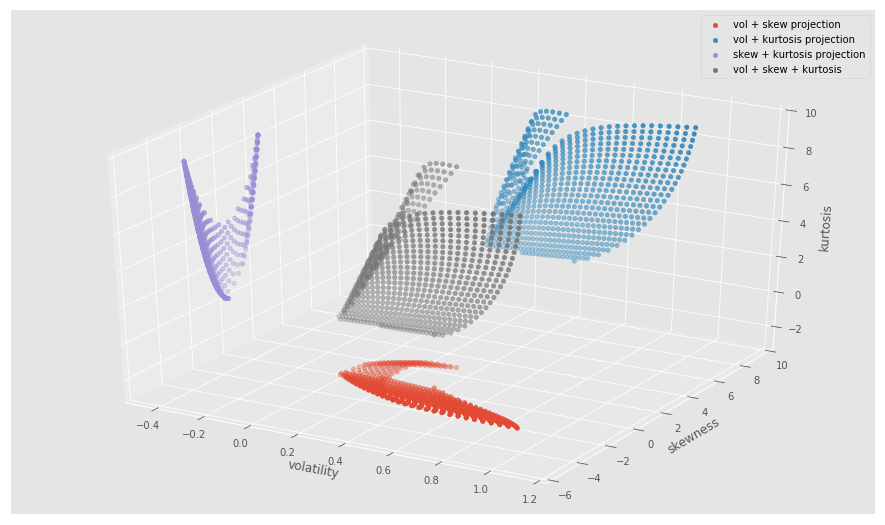

In [61]:
from mpl_toolkits.mplot3d import Axes3D

vsk = pd.DataFrame(cmp.vg_dots_to_vol_skew_kurtosis(cmp.vg_initial_dots), columns=['vol', 'skew', 'kurt'])

he_best = score_he == max_score
vg_best = score_vg == max_score
ls_best = score_ls == max_score

vsk['best'] = np.array(['he'] * vsk.shape[0])
vsk.loc[ls_best, 'best'] = 'ls'
vsk.loc[vg_best, 'best'] = 'vg'
vsk.head()

vol = vsk['vol'].values
skew = vsk['skew'].values
kurt = vsk['kurt'].values

x_min = -.5
x_max = 1.2
y_min = -6
y_max = 10
z_min = -3
z_max = 10

fig = pl.figure()
ax3 = Axes3D(fig)

ax3.set_xlim([x_min, x_max])
ax3.set_ylim([y_min, y_max])
ax3.set_zlim([z_min, z_max])

ax3.scatter(vol, skew, zs=z_min, zdir='z', label='vol + skew projection')
ax3.scatter(vol, kurt, zs=y_max, zdir='y', label='vol + kurtosis projection')
ax3.scatter(skew, kurt, zs=x_min, zdir='x', label='skew + kurtosis projection')

ax3.scatter(vol, skew, kurt, label='vol + skew + kurtosis')

ax3.set_xlabel('volatility')
ax3.set_ylabel('skewness')
ax3.set_zlabel('kurtosis')

pl.legend()
pl.savefig(f'{img_dir}/vol_skew_kurt_all_dots.png')    

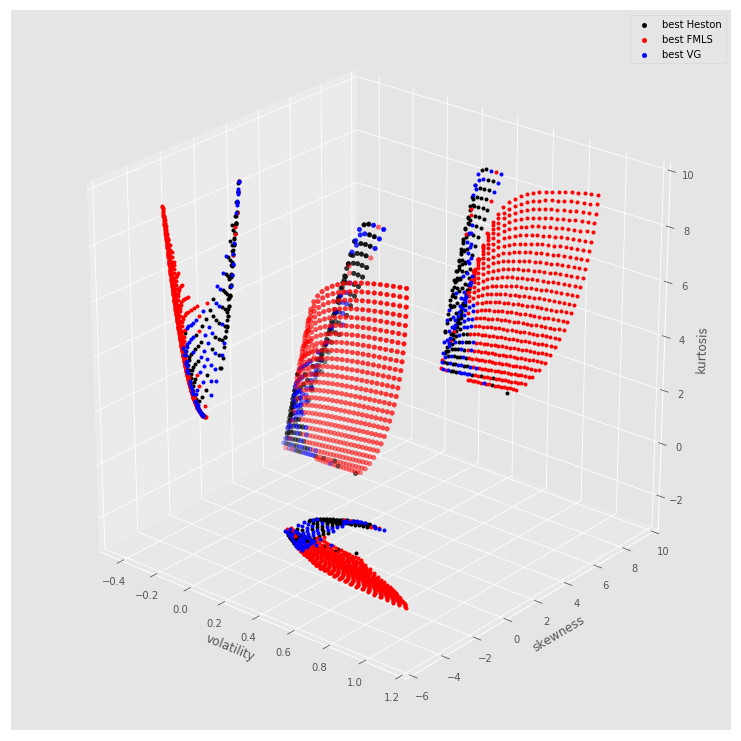

In [62]:
from mpl_toolkits.mplot3d import Axes3D

fig = pl.figure(figsize=(10, 10))
ax3 = Axes3D(fig)
ax3.set_xlim([x_min, x_max])
ax3.set_ylim([y_min, y_max])
ax3.set_zlim([z_min, z_max])
ax3.set_xlabel('volatility')
ax3.set_ylabel('skewness')
ax3.set_zlabel('kurtosis')
ax3.view_init(25, 310)

for best, model in zip([he_best, ls_best, vg_best], ['Heston', 'FMLS', 'VG']):
    ax3.plot(vol[best], skew[best], f"{colors[model]}.", zs=z_min, zdir='z')
    ax3.plot(vol[best], kurt[best], f"{colors[model]}.", zs=y_max, zdir='y')
    ax3.plot(skew[best], kurt[best], f"{colors[model]}.", zs=x_min, zdir='x')
    
    ax3.scatter(vol[best], skew[best], kurt[best], c=colors[model], label=f'best {model}')

pl.legend()  
save_picture('vol_skew_kurt')
pl.show()

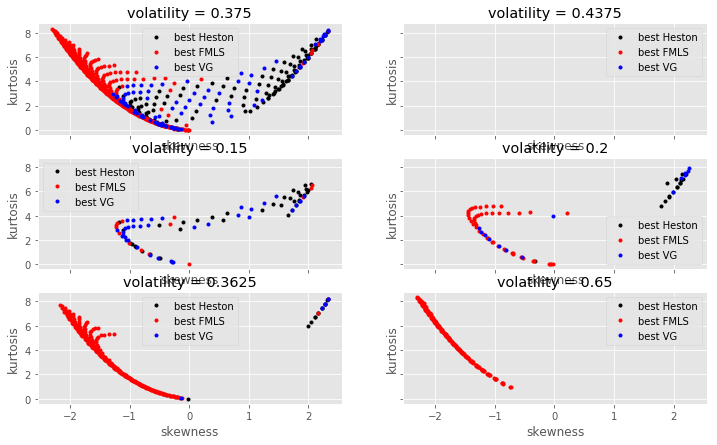

In [63]:
edges = [.75, .125, .175, .225, .5, .8]
prev_edge = 0

_, axarr = pl.subplots(3, 2, sharex=True, sharey=True)
def gen(): 
    for x in range(3):
        for y in range(2):
            yield x, y
            
ind_gen = gen()

for edge in edges:
    ind = ind_gen.__next__()
    vol_group = np.logical_and(vol >= prev_edge, vol < edge)
    frame = axarr[ind[0]][ind[1]]
    for m, label in [('he', 'Heston'), ('ls', 'FMLS'), ('vg', "VG")]:
        frame.plot(skew[np.logical_and(vsk.best == m, vol_group)], kurt[np.logical_and(vsk.best == m, vol_group)], f"{colors[m]}.", label=f'best {label}')
    frame.set_title(f'volatility = {(prev_edge + edge) / 2}')
    prev_edge = edge
    frame.set_xlabel('skewness')
    frame.set_ylabel('kurtosis')
    frame.legend()
#     save_picture()

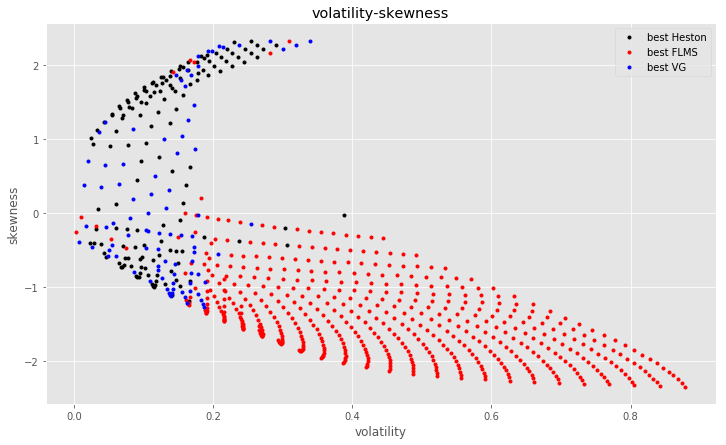

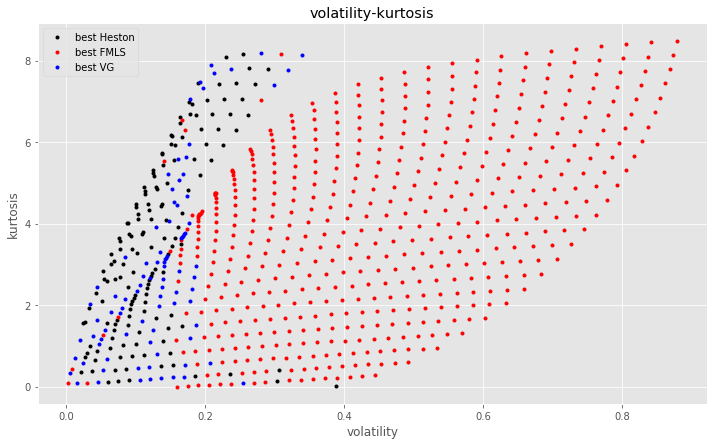

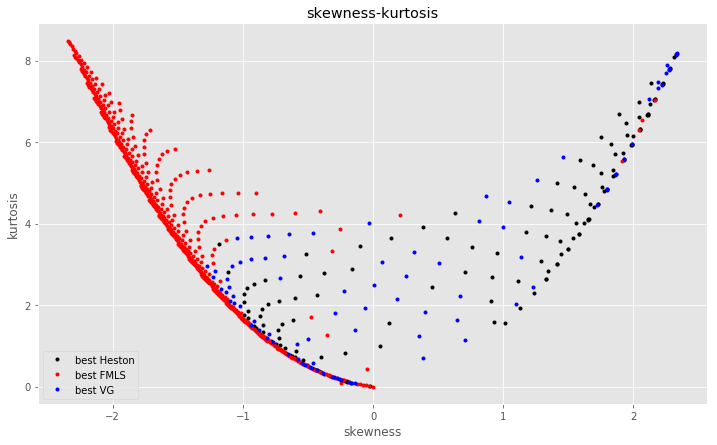

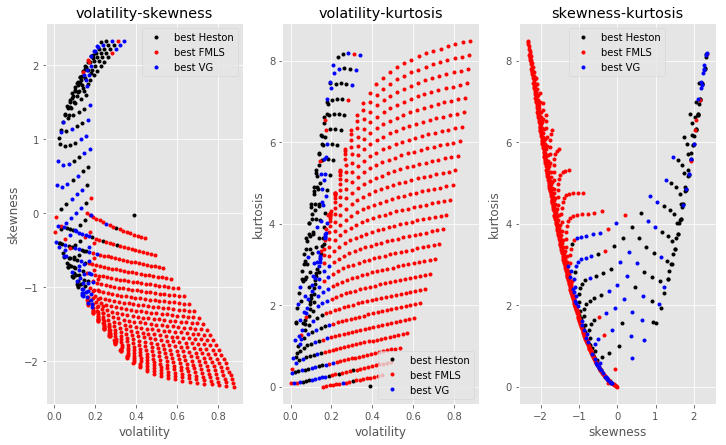

In [67]:
pl.plot(vol[he_best], skew[he_best], "k.", label='best Heston')
pl.plot(vol[ls_best], skew[ls_best], "r.", label='best FLMS')
pl.plot(vol[vg_best], skew[vg_best], "b.", label='best VG')
pl.legend()
pl.xlabel('volatility')
pl.ylabel('skewness')
pl.title('volatility-skewness')
save_picture('vol_skew')
pl.show()

pl.plot(vol[he_best], kurt[he_best], "k.", label='best Heston')
pl.plot(vol[ls_best], kurt[ls_best], "r.", label='best FMLS')
pl.plot(vol[vg_best], kurt[vg_best], "b.", label='best VG')
pl.legend()
pl.xlabel('volatility')
pl.ylabel('kurtosis')
pl.title('volatility-kurtosis')
save_picture('vol_kurt')
pl.show()

pl.plot(skew[he_best], kurt[he_best], "k.", label='best Heston')
pl.plot(skew[ls_best], kurt[ls_best], "r.", label='best FMLS')
pl.plot(skew[vg_best], kurt[vg_best], "b.", label='best VG')
pl.legend()
pl.xlabel('skewness')
pl.ylabel('kurtosis')
pl.title('skewness-kurtosis')
save_picture('skew_kurt')
pl.show()


_, axarr = pl.subplots(1, 3)

axarr[0].plot(vol[he_best], skew[he_best], "k.", label='best Heston')
axarr[0].plot(vol[ls_best], skew[ls_best], "r.", label='best FMLS')
axarr[0].plot(vol[vg_best], skew[vg_best], "b.", label='best VG')
axarr[0].legend()
axarr[0].set_xlabel('volatility')
axarr[0].set_ylabel('skewness')
axarr[0].set_title('volatility-skewness')

axarr[1].plot(vol[he_best], kurt[he_best], "k.", label='best Heston')
axarr[1].plot(vol[ls_best], kurt[ls_best], "r.", label='best FMLS')
axarr[1].plot(vol[vg_best], kurt[vg_best], "b.", label='best VG')
axarr[1].legend()
axarr[1].set_xlabel('volatility')
axarr[1].set_ylabel('kurtosis')
axarr[1].set_title('volatility-kurtosis')

axarr[2].plot(skew[he_best], kurt[he_best], "k.", label='best Heston')
axarr[2].plot(skew[ls_best], kurt[ls_best], "r.", label='best FMLS')
axarr[2].plot(skew[vg_best], kurt[vg_best], "b.", label='best VG')
axarr[2].legend()
axarr[2].set_xlabel('skewness')
axarr[2].set_ylabel('kurtosis')
axarr[2].set_title('skewness-kurtosis')

pl.rcParams["figure.figsize"] = (20, 10)   
save_picture('vol_skew_kurt_projections')
pl.show()

pl.rcParams["figure.figsize"] = (15, 10)  

vol      skew      kurt best
0  0.339028  2.330633  8.148518   vg
1  0.309579  2.332955  8.167028   ls
2  0.281277  2.333269  8.176481   vg
3  0.254539  2.328195  8.162208   he
4  0.229951  2.309478  8.090456   he

In [ ]:
vol_step = .05
vol_max = 
he_skew_0_2 = he_skew[he_vol <= .2]

In [7]:
for m in cmp.models:
    global_scores[m] /= sum_scores

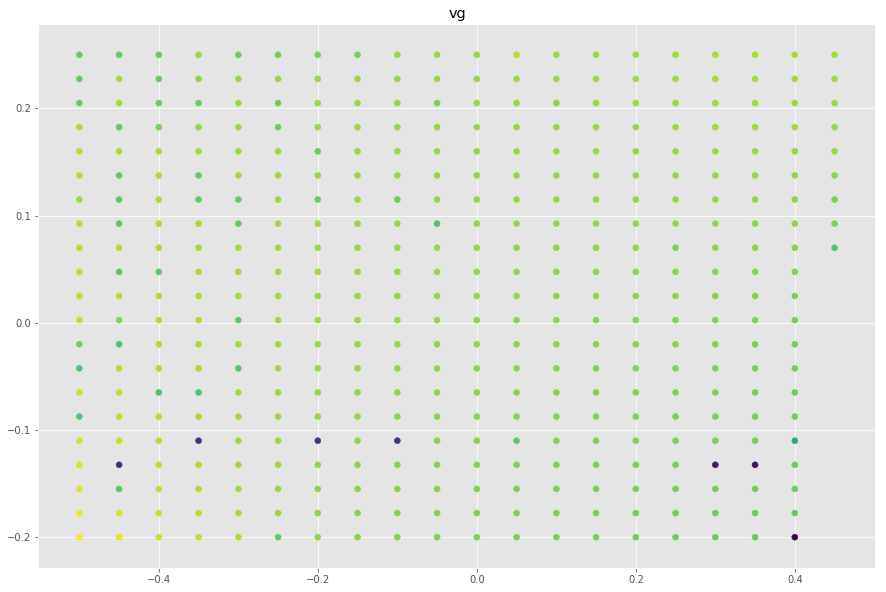

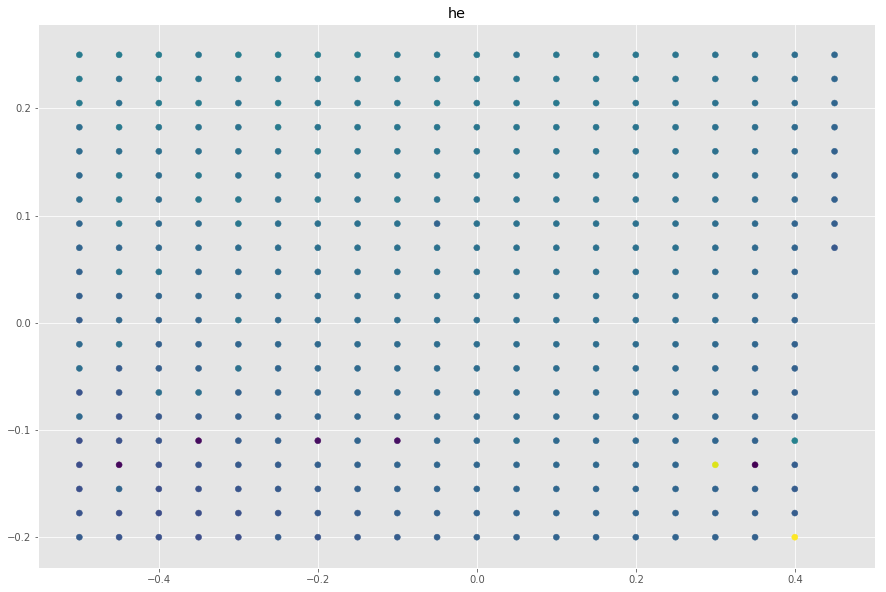

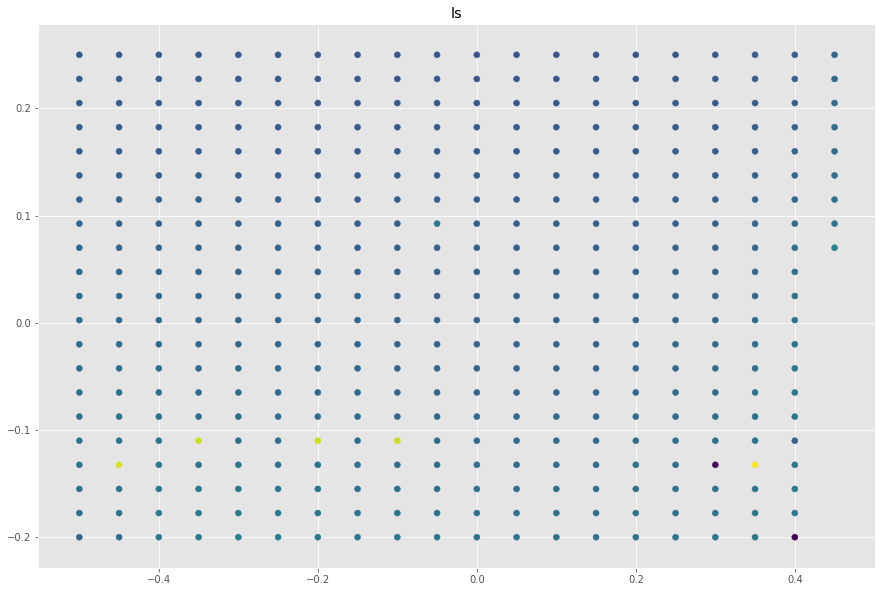

In [8]:
for m in cmp.models:
    df = pd.DataFrame(dots_2d, columns=['x', 'y'])
    pl.title(m)
    pl.scatter(df.x, df.y, c=list(global_scores[m]))
    pl.show()

In [16]:
try:
    data, info = hf.read_data("../SPH2_031612.csv")
except FileNotFoundError:
    data, info = hf.read_data("SPH2_031612.csv")

In [17]:
try:
    data = hf.get_prepared_data()
except FileNotFoundError:
    print("Preparing data...")
    data, info = dh.prepare_data(data=data, info=info)
    print("Done")

In [18]:
import warnings
warnings.filterwarnings("ignore", message='numpy.dtype size changed')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings('ignore', message="can't resolve package from __spec__ or __package__, ")
warnings.filterwarnings('ignore', message="is deprecated")
fc = reload(fc)

ls [ 1.45807464  0.11551038]
vg [ 0.83828823 -0.18804145  0.17909661]
heston [  9.50123966e+00   3.62756212e-03   1.90385676e+00  -7.85030428e-01
   3.83842730e-01]


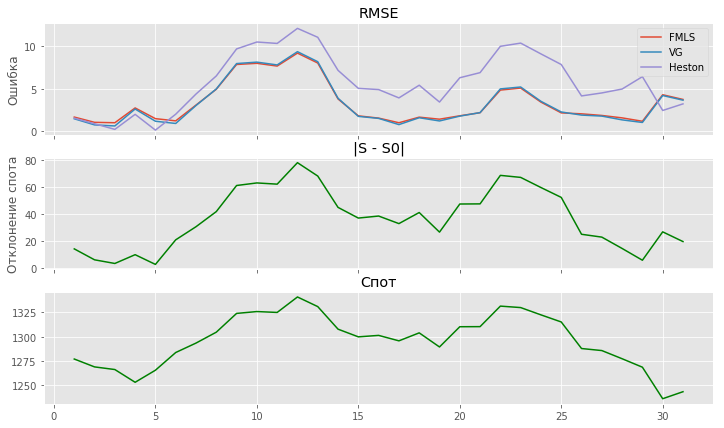

ls [ 1.47843353  0.1258917 ]
vg [ 0.63117065 -0.22950055  0.17994868]
heston [ 8.79362399  0.0544654   1.74559615 -0.81940169  0.09160087]


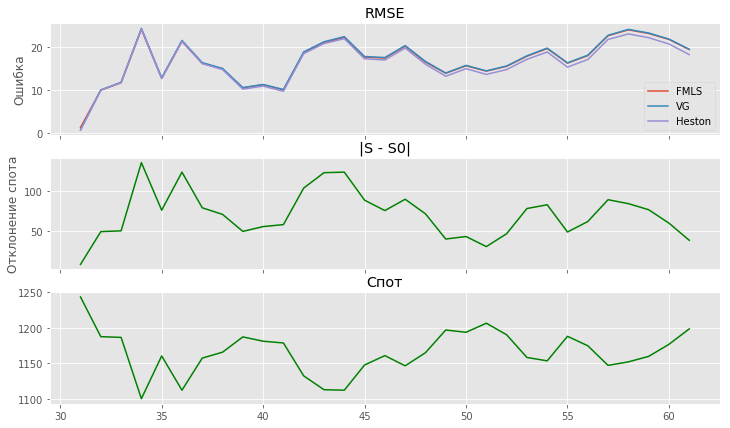

ls [ 1.43315445  0.17969907]
vg [ 0.56224526 -0.33607786  0.25726055]
heston [ 8.0922724   0.02015945  2.         -0.78690176  0.42609161]


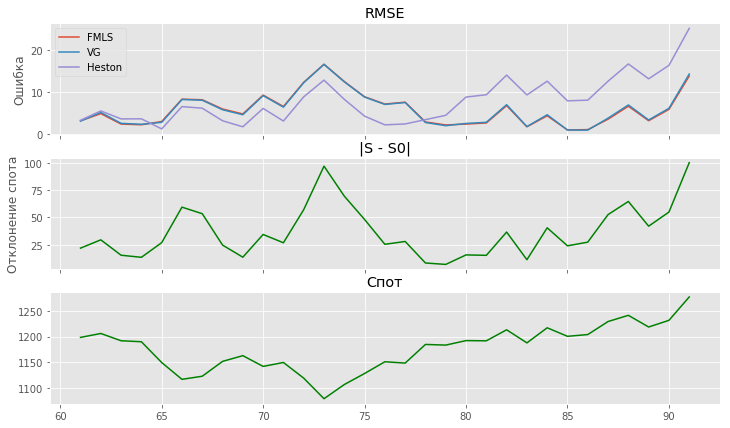

ls [ 1.45142861  0.16458453]
vg [ 0.4686427 -0.3314469  0.2250998]
heston [ 6.61894515  0.06662246  1.68739098 -0.80124787  0.14410364]


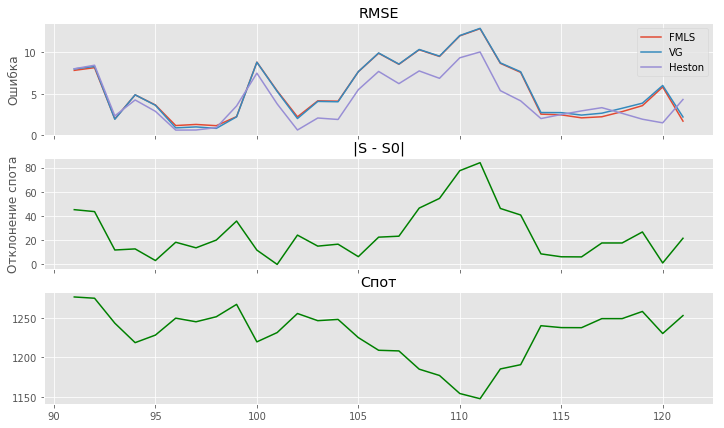

ls [ 1.51895787  0.18954434]
vg [ 0.27821009 -0.42856631  0.24314759]
heston [ 6.88701146  0.14689     1.8671047  -0.78281086  0.04935616]


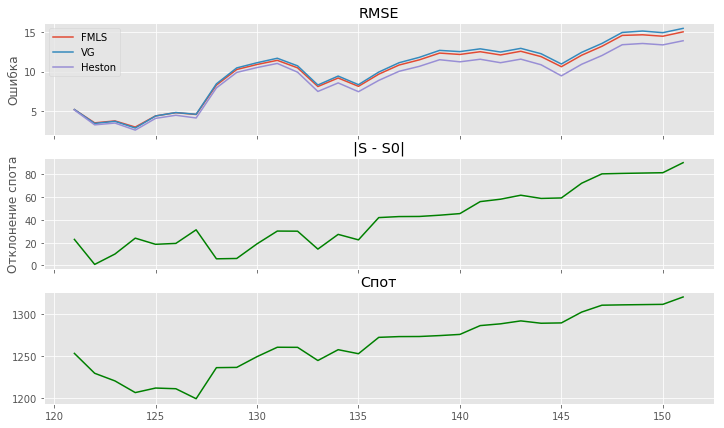

ls [ 1.62354486  0.12029519]
vg [ 0.16311501 -0.30220829  0.15288995]
heston [ 19.44798781   0.03368928   1.98702303  -0.70311889   0.04631872]


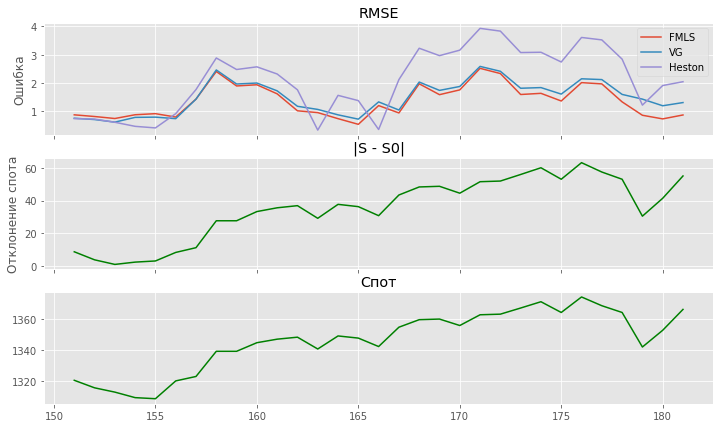

In [59]:
metric = "RMSE"
to_forecast = 30
interval = to_forecast
use_trend = False

for start_day in range(0, len(info) - to_forecast - 1, interval):
    f, axarr = pl.subplots(nrows=3, ncols=1, sharex='col')
    
    for model in ['ls', 'vg', 'heston']:
        day = start_day
        
        forecast_start, forecast_end = day + 1, day + 1 + to_forecast + 1
        forecast_days = range(forecast_start, forecast_end)
        pars = fc.get_calibrated_pars(model=model, metric=metric, day=day)
        print(model, pars)

        predicted = fc.forecast(model=model, days=forecast_days, pars=pars, data=data, info=info, use_trend=use_trend, metric=metric)
        actual = list(map(lambda x: np.append(*x), 
                          list(zip(data.prices[True][forecast_start:forecast_end], data.prices[False][forecast_start:forecast_end]))))
        
        axarr[0].plot(forecast_days, fc.evaluate(predicted=predicted, actual=actual, metric=metric), label=hf.title(model))

    axarr[0].legend()
    axarr[0].set_title(f"{metric}")
    axarr[0].set_ylabel('Ошибка')

    spots = np.array(list(map(lambda d: info[d].spot, forecast_days)))
    axarr[1].plot(forecast_days, np.abs(spots - info[day].spot), 'g', label='spot change')
    axarr[1].set_title('|S - S0|')
    axarr[1].set_ylabel('Отклонение спота')
    
    axarr[2].plot(forecast_days, spots, 'g')
    axarr[2].set_title('Спот')
#     axarr[2].set_ylabel('Значение спота')
    
    save_picture(f'forecast_{start_day}_{interval}')
    pl.show()
    pass

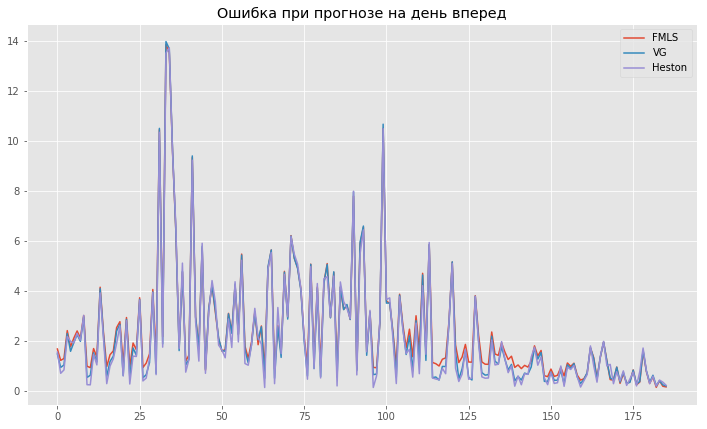

In [58]:
from gen_pricer import GenPricer
from structs import EvalArgs
from optimization import metrics

metric = "RMSE"
rate = .008
    
for model in ['ls', 'vg', 'heston']:
    errors = []
    pricer = GenPricer(model=model,
                           market=None,
                           use_fft=True)
    for day in range(1, len(info)):
        pars = fc.get_calibrated_pars(model=model, metric=metric, day=day-1)
        pricer.market = EvalArgs.from_structure(data=data, info=info, rate=rate, day=day)
        predicted = np.append(*pricer.price(pars=pars))
        actual = np.append(data.prices[True][day], data.prices[False][day])
#         print(len(predicted), len(actual))
        errors.append(metrics[metric](predicted=predicted, actual=actual))
        
    pl.plot(errors, label=hf.title(model))
    
pl.title('Ошибка при прогнозе на день вперед')    
pl.legend()
save_picture(f'forecast_1_forward')
pl.show()

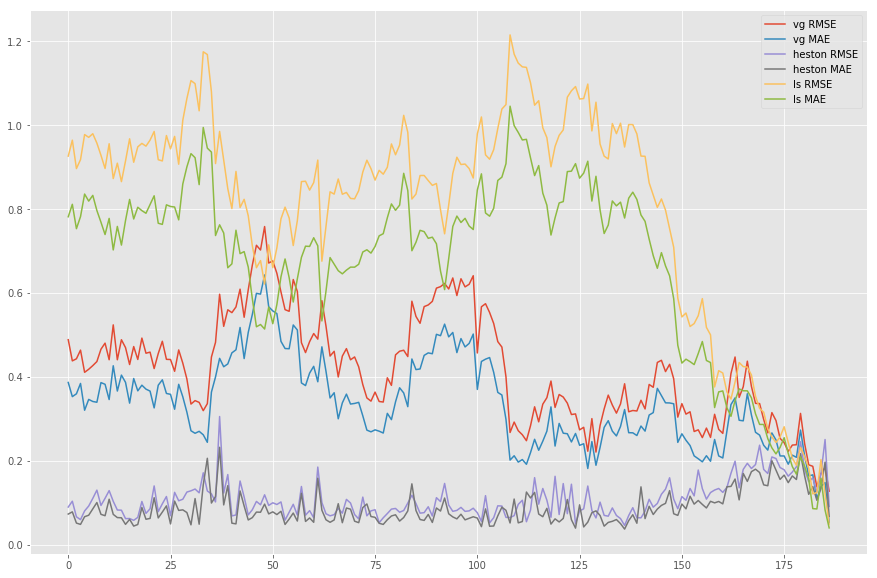

In [12]:
metric = "RMSE"
to_forecast = 30
interval = 30
use_trend = True

for start_day in range(0, len(info) - to_forecast - 1, interval):
    f, axarr = pl.subplots(nrows=3, ncols=1)
    
    for model in ['ls', 'vg', 'heston']:
        day = start_day
        
        forecast_start, forecast_end = day + 1, day + 1 + to_forecast + 1
        forecast_days = range(forecast_start, forecast_end)
        pars = fc.get_calibrated_pars(model=model, metric=metric, day=day)
        print(model, pars)

        predicted = fc.forecast(model=model, days=forecast_days, pars=pars, data=data, info=info, use_trend=use_trend, metric=metric)

        actual = list(map(lambda x: np.append(*x), 
                          list(zip(data.prices[True][forecast_start:forecast_end], data.prices[False][forecast_start:forecast_end]))))

        # print(model, np.array(fc.evaluate(predicted=predicted, actual=actual, metric=metric)))
#         axarr[0].plot(forecast_days, predicted, label=f'hf.title(model) predicted')
        
        try:
            axarr[0].plot(forecast_days, fc.evaluate(predicted=predicted, actual=actual, metric=metric), label=hf.title(model))
        except ValueError as e:
            print(model, len(predicted), len(actual))
            raise e

    axarr[0].legend()
    axarr[0].set_title(f"{metric}")
    axarr[0].set_ylabel('Ошибка')

    spots = np.array(list(map(lambda d: info[d].spot, forecast_days)))
    axarr[1].plot(forecast_days, np.abs(spots - info[day].spot), 'g', label='spot change')
    axarr[1].set_title('|S - S0|')
    axarr[1].set_ylabel('Отклонение от начального спота')
    
    axarr[2].plot(forecast_days, spots, 'g', label='spot')
    axarr[2].set_title('spot')
    axarr[2].set_ylabel('Значение спота')
    
    save_picture(f'forecast_{start_day}_{interval}')
    pl.show()
    pass

In [43]:
from heston_pricing import price_heston
from vg_pricing import price_vg
from ls_pricing import price_ls
from gen_pricer import GenPricer
from structs import EvalArgs
import optimization as opt

ValueError: x and y must have same first dimension, but have shapes (73,) and (1,)

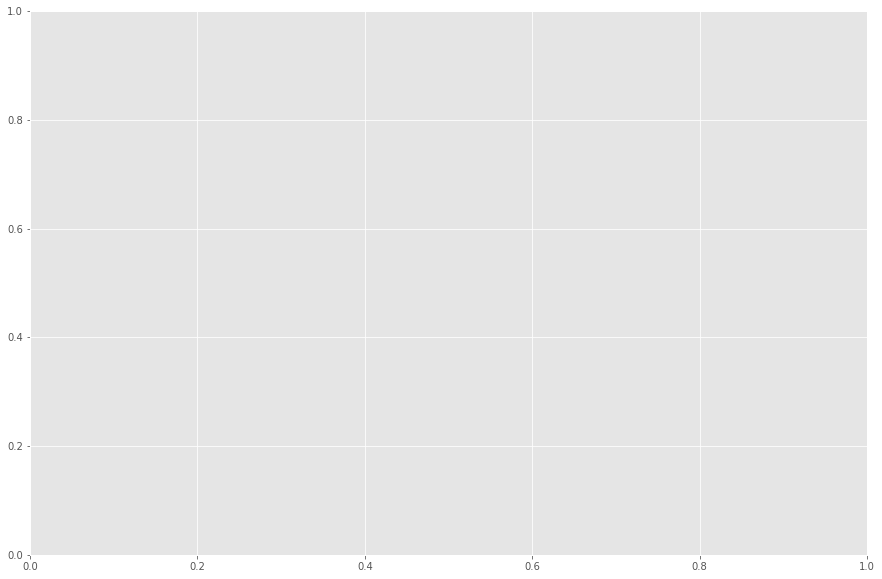

In [44]:
day = 15
is_call = True
prices = np.array(data.prices[is_call][day])
strikes = np.array(data.strikes[is_call][day])
pars_vg = fc.get_calibrated_pars(model='vg', metric=metric, day=day)
pars_ls = fc.get_calibrated_pars(model='ls', metric=metric, day=day)
pars_he = fc.get_calibrated_pars(model='heston', metric=metric, day=day)
pricer_vg = GenPricer(model='vg', market=EvalArgs.from_structure(data=data, info=info, rate=.008, day=day), use_fft=True)
pricer_ls = GenPricer(model='ls', market=EvalArgs.from_structure(data=data, info=info, rate=.008, day=day), use_fft=True)
pricer_he = GenPricer(model='heston', market=EvalArgs.from_structure(data=data, info=info, rate=.008, day=day), use_fft=True)
if is_call:
    prices_vg, _ = pricer_vg.price(pars=pars_vg)
    prices_ls, _ = pricer_ls.price(pars=pars_ls)
    prices_he, _ = pricer_he.price(pars=pars_he)
else:
    _, prices_vg = pricer_vg.price(pars=pars_vg)
    _, prices_ls = pricer_ls.price(pars=pars_ls)
    _, prices_he = pricer_he.price(pars=pars_he)

lw = 2
pl.plot(strikes, opt.mae(prices_vg, prices), label='vg error', linewidth=lw, color='b')
pl.plot(strikes, opt.mae(prices_ls, prices), label='ls error', linewidth=lw, color='r')
pl.plot(strikes, opt.mae(prices_he - prices), label='heston error', linewidth=lw, color='g')
pl.legend()
pass

### Parameters evolution over time

In [41]:
days = range(187)
lw1 = 10
lw2 = 7
lw3 = 3

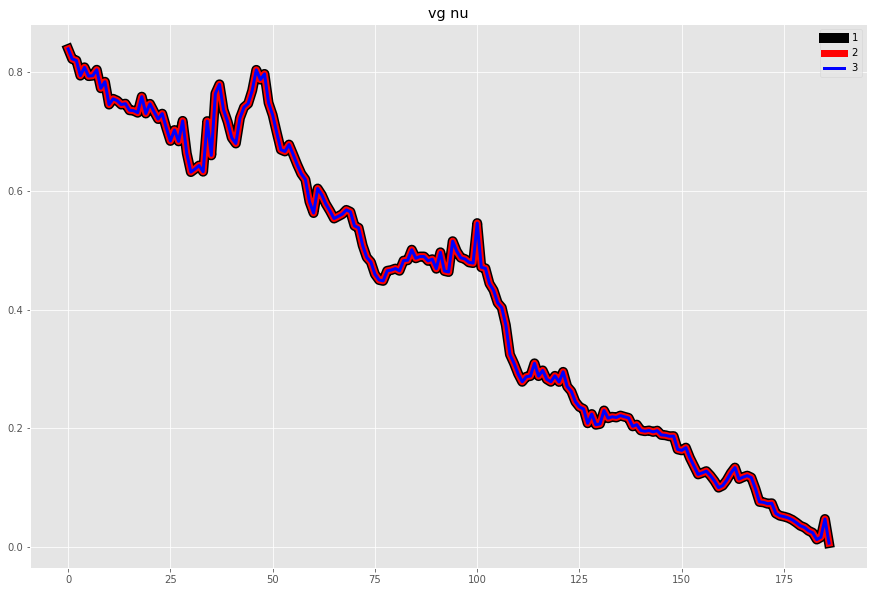

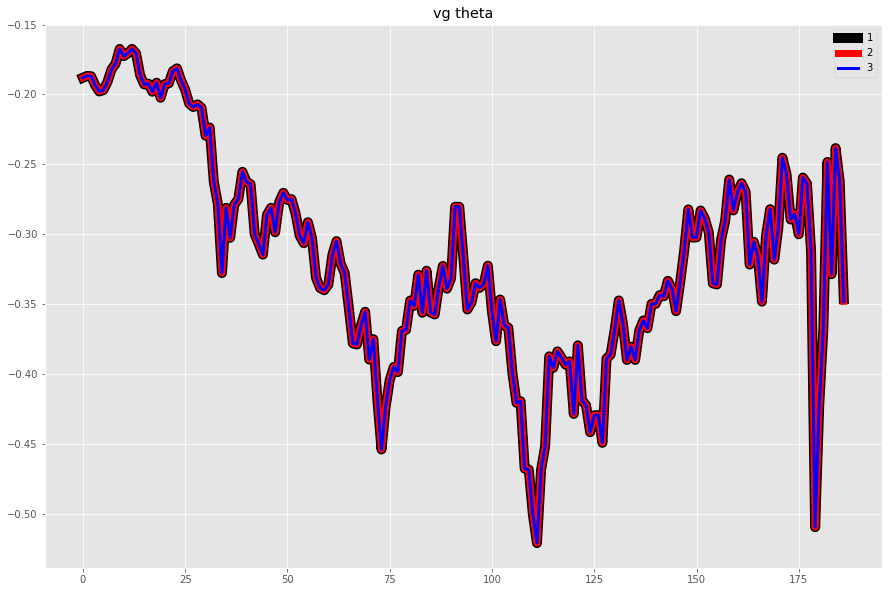

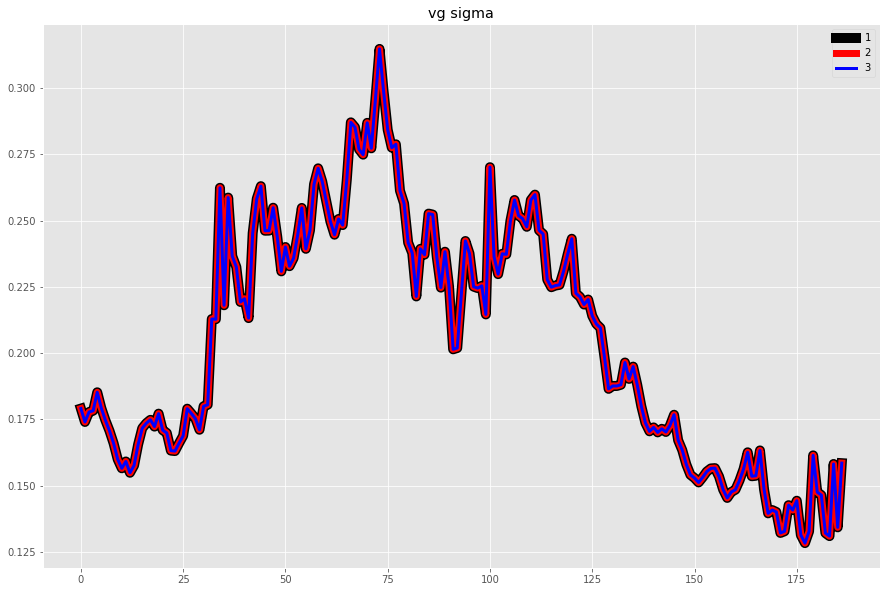

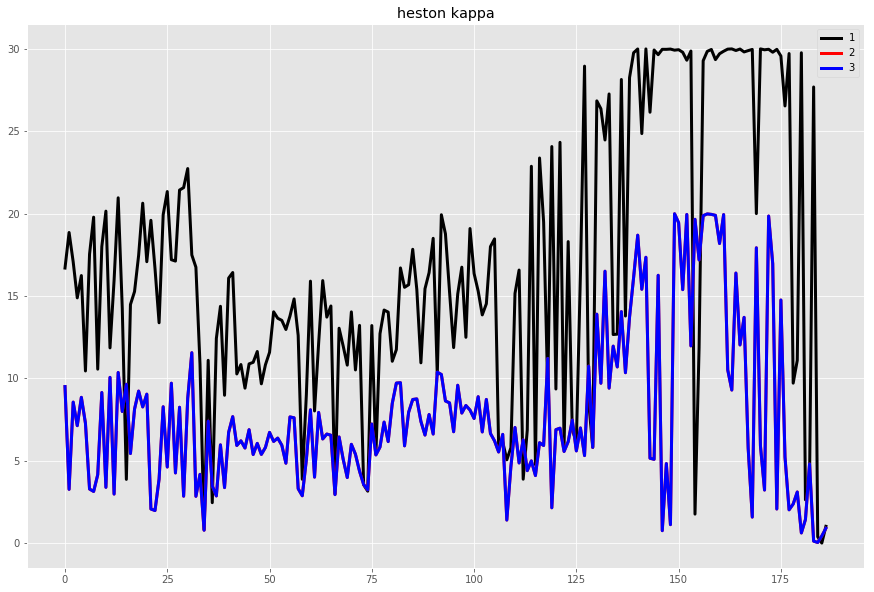

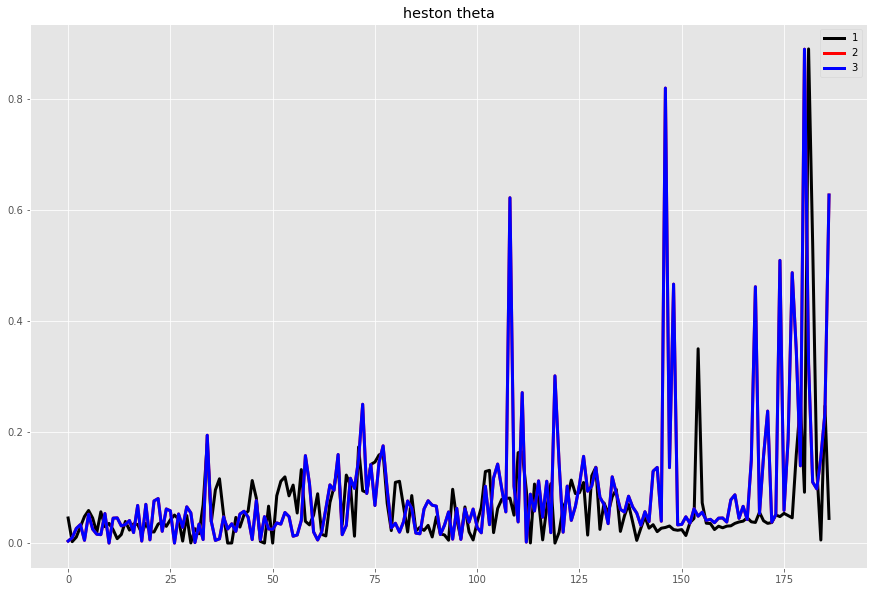

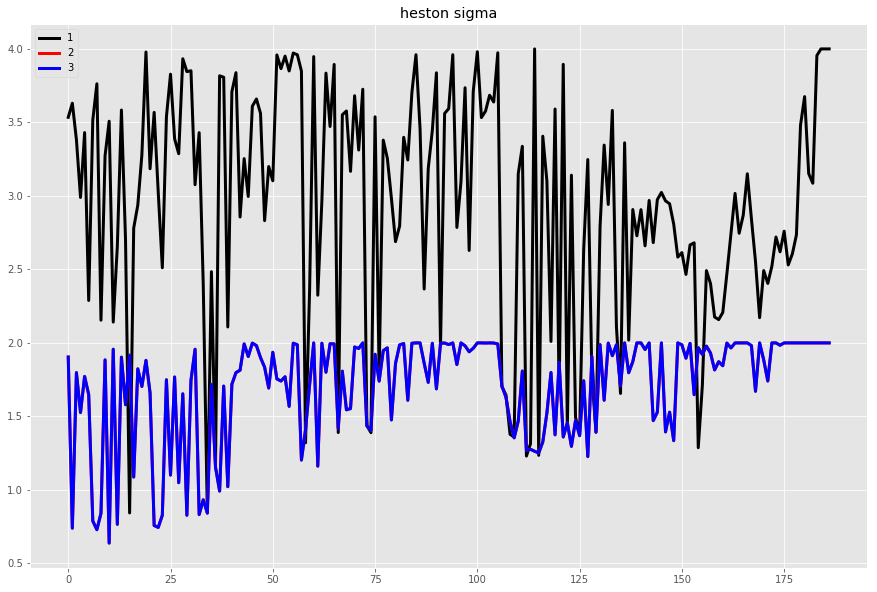

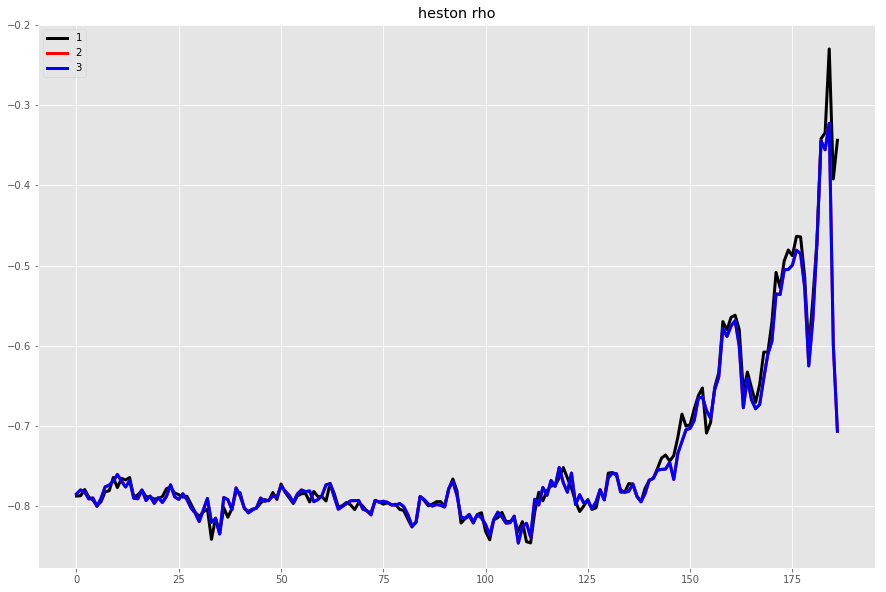

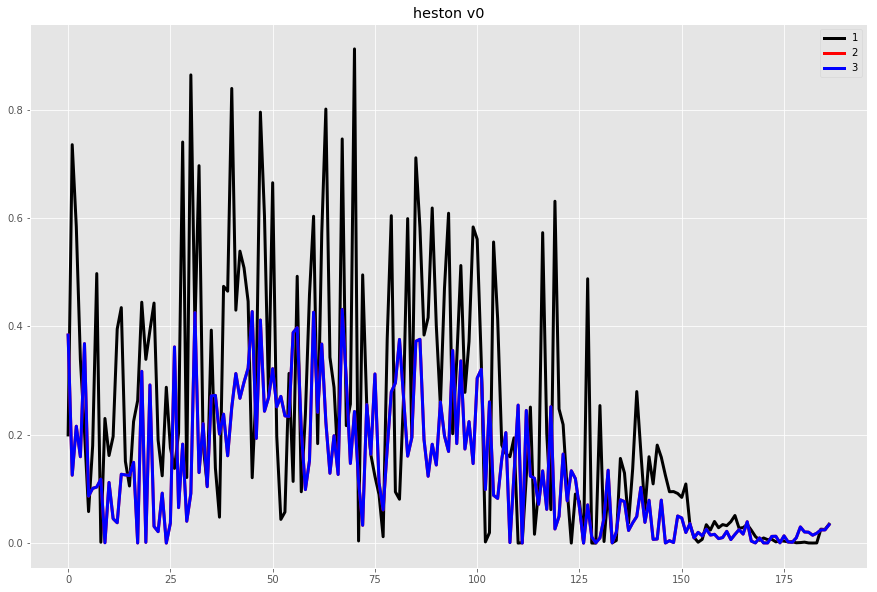

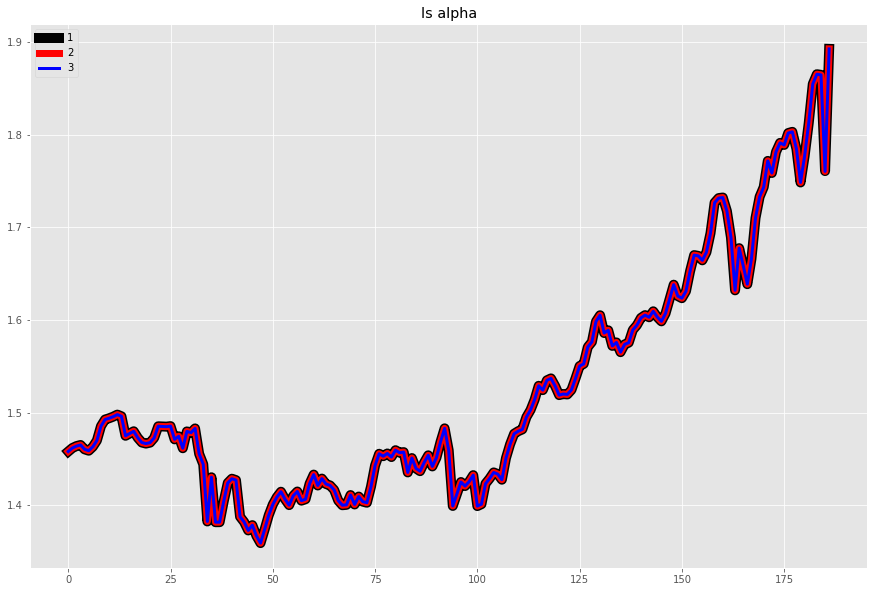

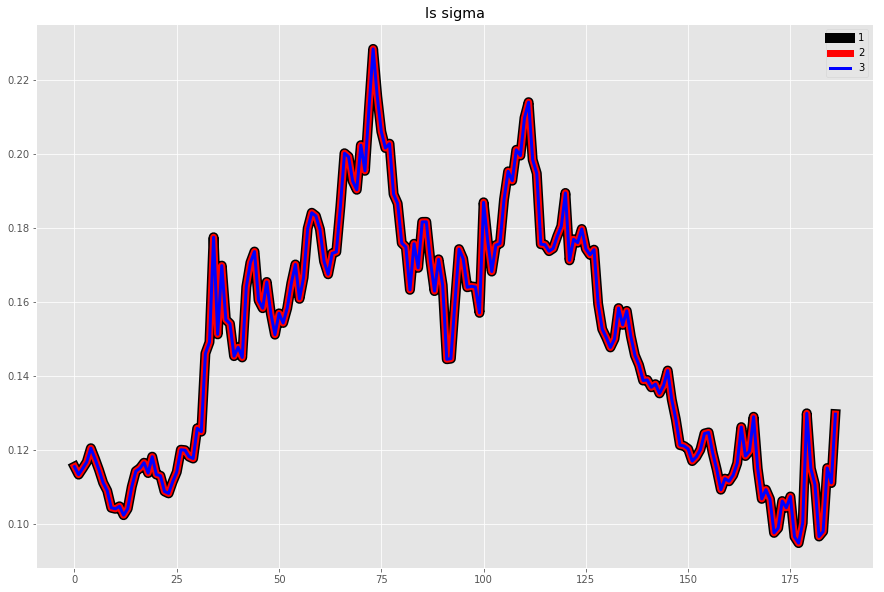

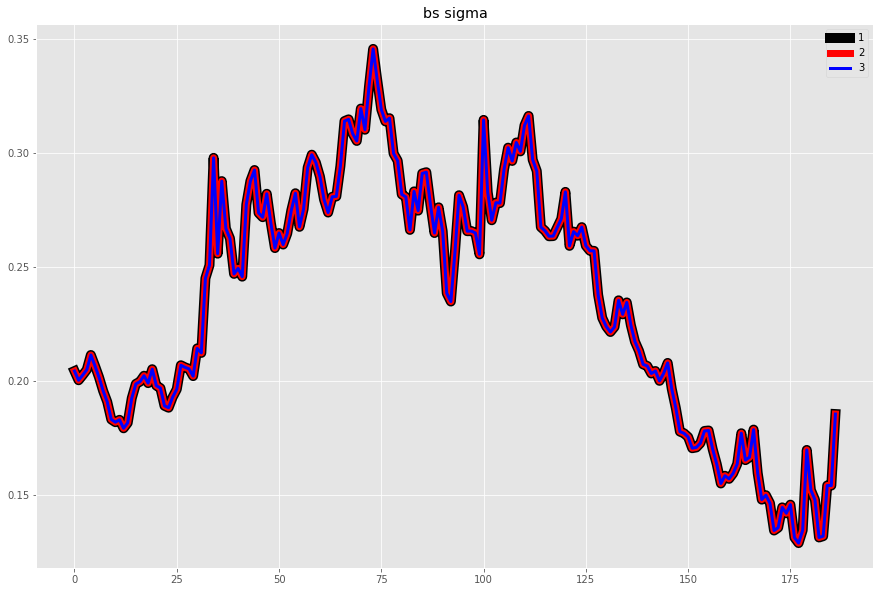

In [42]:
metric = "RMSE"
for model in cmp.models + ['bs']:
    if model == 'he':
        model = 'heston'
    df3 = hf.get_params(filename=hf.get_filename(model=model, metric=metric), model=model)
    df2 = hf.get_params(filename=f'params/best1/best4{model}_{metric}_all.txt', model=model)
    df1 = hf.get_params(filename=f'params/best0/best4{model}_{metric}_all.txt', model=model)
    for col in df1.columns[1:]:
        pl.plot(days, df1.loc[days, col], label='1', linewidth=3 if model == 'heston' else lw1, color='k')
        pl.plot(days, df2.loc[days, col], label='2', linewidth=3 if model == 'heston' else lw2, color='r')
        pl.plot(days, df3.loc[days, col], label='3', linewidth=3 if model == 'heston' else lw3, color='b')
        pl.title(f'{model} {col}')
        pl.legend()
        pl.show()


(187, 3)


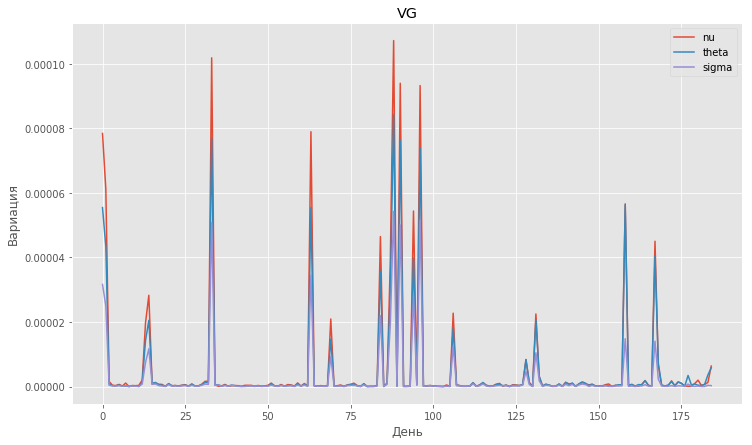

(187, 5)


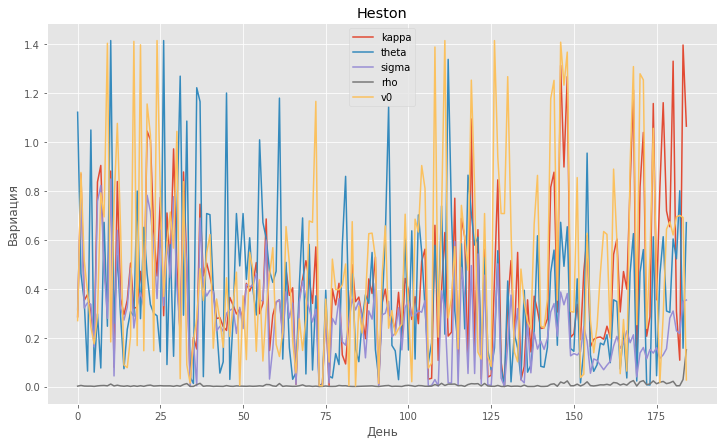

(187, 2)


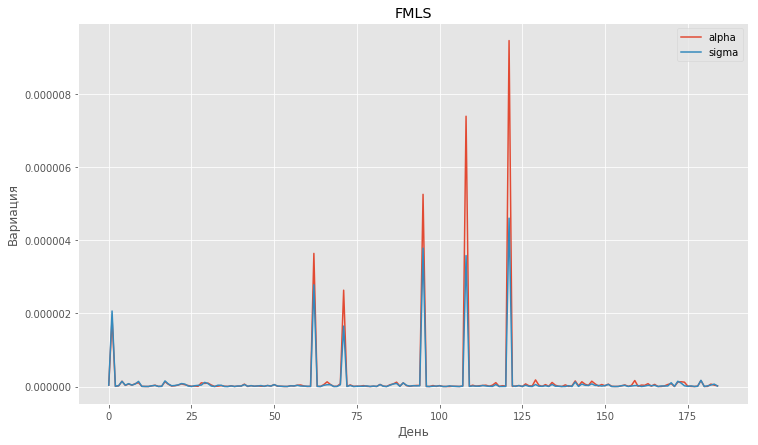

(187, 1)


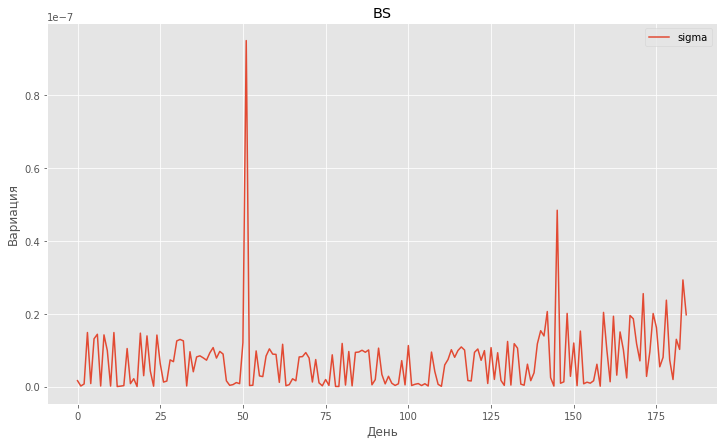

In [82]:
days = range(185)
metric = "RMSE"
pl.rcParams["figure.figsize"] = (12, 7)
for model in cmp.models + ['bs']:
    if model == 'he':
        model = 'heston'
    df3 = hf.get_params(filename=hf.get_filename(model=model, metric=metric), model=model)
    df2 = hf.get_params(filename=f'params/best1/best4{model}_{metric}_all.txt', model=model)
    df1 = hf.get_params(filename=f'params/best0/best4{model}_{metric}_all.txt', model=model)
    all_df = np.array(list(zip(df1.drop(columns="score").values, df2.drop(columns="score").values, df3.drop(columns="score").values)))
    std_df = all_df.std(axis=1)
    mean_df = np.abs(all_df).mean(axis=1)
    columns = df1.columns
    counter = 1
    ax = pl.figure().add_subplot(111)
    for arr in np.hsplit(std_df / mean_df, range(1, std_df.shape[1])): 
        arr = arr.flatten()
        ax.plot(days, arr[days], label=columns[counter])
        counter += 1
    ax.set_xlabel("День")
    ax.set_ylabel("Вариация")
    pl.title(f'{hf.title(model)}')
    pl.legend()
    save_picture(f'{model}_stable')
    pl.show()

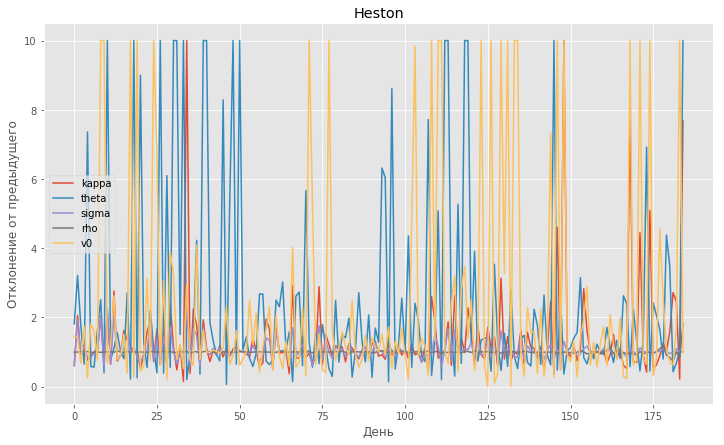

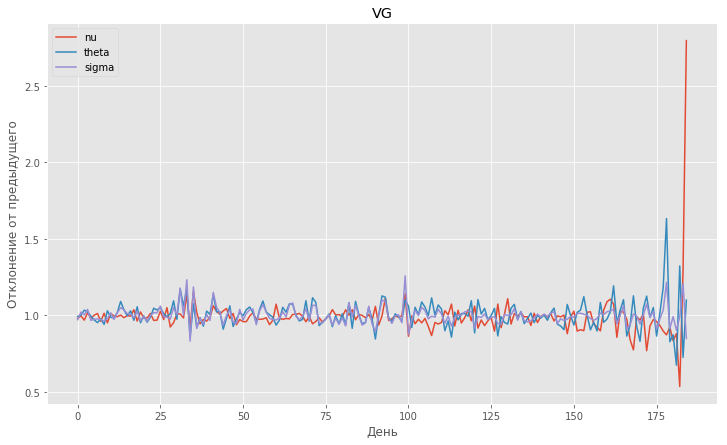

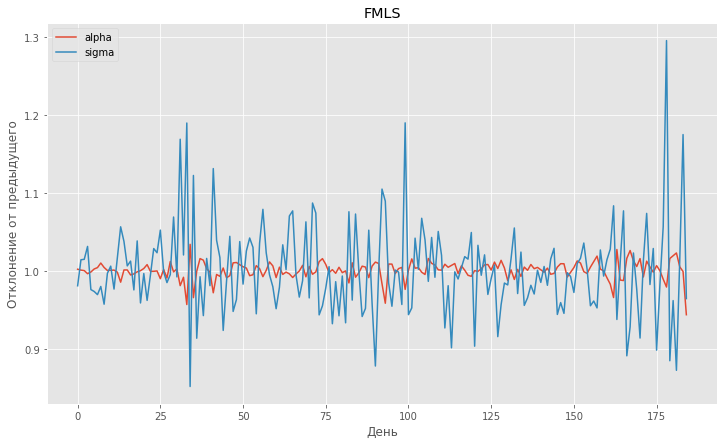

In [108]:
from scipy.ndimage.interpolation import shift
from config import named_params

days = range(185)
metric = 'RMSE'
for model in ['heston', 'vg', 'ls']:
    df3 = hf.get_params(filename=hf.get_filename(model=model, metric=metric), model=model)
    df2 = hf.get_params(filename=f'params/best1/best4{model}_{metric}_all.txt', model=model)
    df1 = hf.get_params(filename=f'params/best0/best4{model}_{metric}_all.txt', model=model)
    all_df = np.array(list(zip(df1.drop(columns="score").values, df2.drop(columns="score").values, df3.drop(columns="score").values)))
#     print(all_df[:3])
#     print(all_df.mean(axis=1)[:3])
    mean_changes = (all_df / np.roll(all_df, 1, axis=0)).mean(axis=1)
    mean_changes = np.delete(mean_changes, 0, 0)
#     print(np.roll(all_df, 1, axis=1).mean(axis=1)[:3])
#     print(mean_changes[:3])
    mask = mean_changes > 10
    np.place(mean_changes, mask, [10])
    columns = df1.columns
    counter = 1
    ax = pl.figure().add_subplot(111)
    for arr in np.hsplit(mean_changes, range(1, mean_changes.shape[1])):
        arr = arr.flatten()
        ax.plot(days, arr[days], label=columns[counter])
        counter += 1
    ax.set_xlabel("День")
    ax.set_ylabel("Отклонение от предыдущего")
    pl.title(f'{hf.title(model)}')
    pl.legend()
    save_picture(f'{model}_stable_rel')
    pl.show()

### Parameters regression

In [78]:
import warnings
warnings.filterwarnings("ignore", message='numpy.dtype size changed')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings('ignore', message="can't resolve package from __spec__ or __package__, ")

In [79]:
%load_ext autoreload
%autoreload 2

In [80]:
import sklearn.linear_model as lm
from config import named_params

In [100]:
metric = 'RMSE'
model_X = 'ls'
model_y = 'vg'
df_X = hf.get_params(filename=hf.get_filename(model=model_X, metric=metric), model=model_X)
df_y = hf.get_params(filename=hf.get_filename(model=model_y, metric=metric), model=model_y)
X = df_X[named_params[model_X][0]]
y = df_y[named_params[model_y][0]]

In [101]:
lin_regr = lm.LinearRegression(copy_X=True, fit_intercept=True)
lin_regr.fit(X=X, y=y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [153]:
lin_regr.score(X=X, y=y)

0.9124589753284702

In [154]:
np.array(list(zip(df1.drop(columns="score").values, df2.drop(columns="score").values, df3.drop(columns="score").values)))

array([[[ 0.8381489 , -0.18806355,  0.1790846 ],
        [ 0.83828823, -0.18804145,  0.17909661],
        [ 0.83828823, -0.18804146,  0.17909661]],

       [[ 0.82125408, -0.18679633,  0.17404755],
        [ 0.82136064, -0.18677917,  0.17405677],
        [ 0.82125357, -0.18679646,  0.17404747]],

       [[ 0.81891893, -0.18696487,  0.17779943],
        [ 0.81892161, -0.18696457,  0.17779958],
        [ 0.81892257, -0.18696436,  0.17779969]],

       ..., 
       [[ 0.01703945, -0.23839524,  0.15819813],
        [ 0.01703922, -0.23839817,  0.15819804],
        [ 0.01703932, -0.23839705,  0.15819809]],

       [[ 0.04765359, -0.26221169,  0.13430181],
        [ 0.04765439, -0.26221087,  0.13430144],
        [ 0.04765355, -0.2622118 ,  0.1343019 ]],

       [[ 0.0071947 , -0.3463969 ,  0.15849505],
        [ 0.00716404, -0.3479881 ,  0.15852101],
        [ 0.00716443, -0.34797006,  0.15852068]]])

### calibration quality

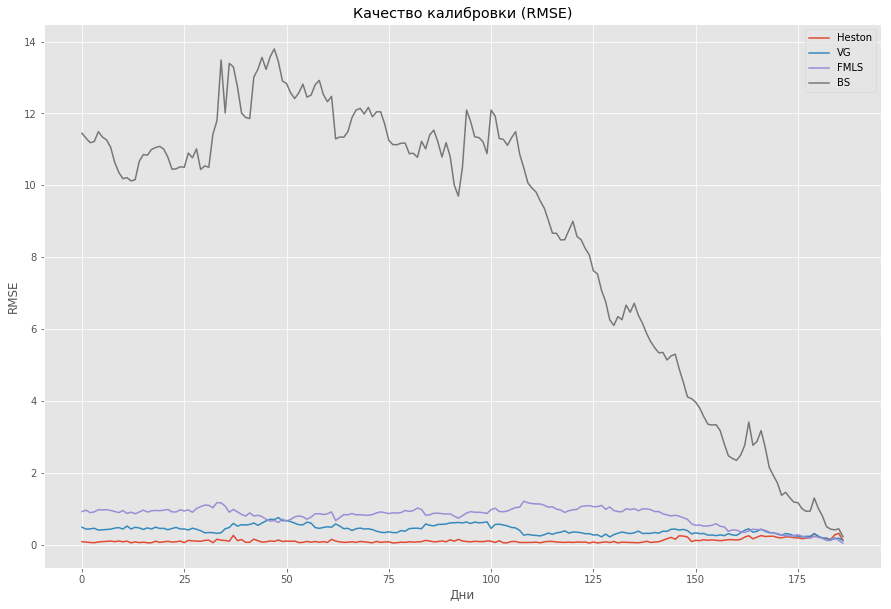

In [141]:
ax = pl.figure().add_subplot(111)
for model in ['heston', 'vg', 'ls', 'bs']:
    evals = hf.get_eval_values(model=model, metric=metric, is_call=None)
    ax.plot(range(len(evals)), evals, label=hf.title(model))
ax.set_xlabel('Дни')
ax.set_ylabel(metric)
pl.title('Качество калибровки (RMSE)')
pl.legend()
save_picture(f'{metric}_quality')
pl.show()

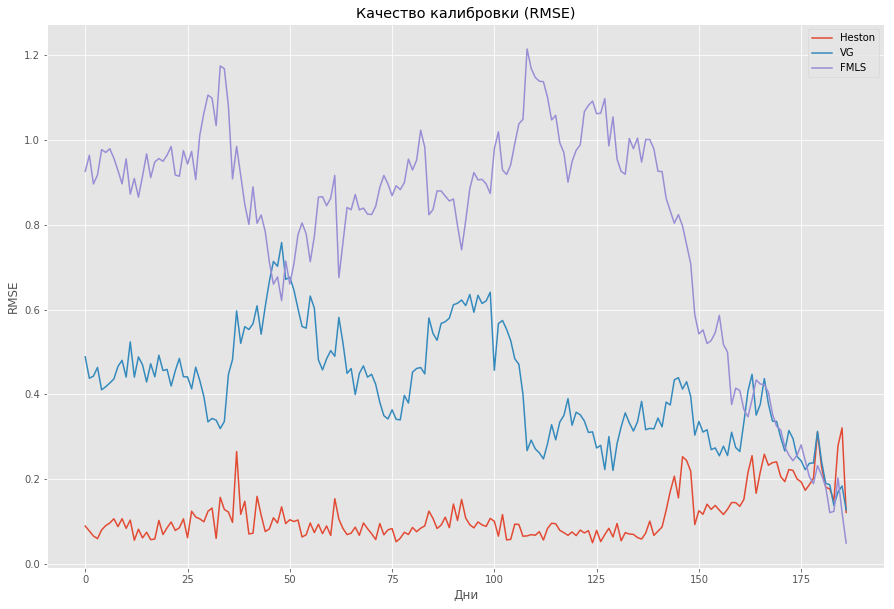

In [6]:
ax = pl.figure().add_subplot(111)
for model in ['heston', 'vg', 'ls']:
    evals = hf.get_eval_values(model=model, metric=metric, is_call=None)
    ax.plot(range(len(evals)), evals, label=hf.title(model))
ax.set_xlabel('Дни')
ax.set_ylabel(metric)
pl.title('Качество калибровки (RMSE)')
pl.legend()
save_picture(f'{metric}_quality_no_BS')
pl.show()

### AIC

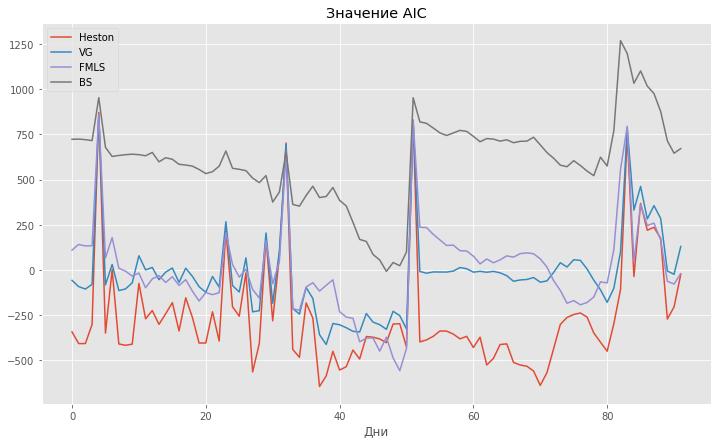

In [82]:
from gen_pricer import GenPricer
from structs import EvalArgs

data, info = hf.read_new_data()
from_dir = "params/backup2017"
d = 91

# data, info = hf.read_data()
# from_dir = "params/backup"
# d = 187

def get_actual(day: int) -> np.ndarray:
    return np.append(data.prices[True][day], data.prices[False][day])

ax = pl.subplot(111)

for model in ['heston', 'vg', 'ls', 'bs']:
    params = hf.get_params(filename=hf.get_filename(model=model, metric=metric, from_dir=from_dir), model=model)
    akaike_scores = []
    for day, pars in params.drop(columns=['score']).iterrows():
        market = EvalArgs.from_structure(data=data, info=info, day=day, rate=.008)
        pricer = GenPricer(model=model, market=market, use_fft=True)
        call_prices, put_prices = pricer.price(pars=pars.values)
        predicted = np.append(call_prices, put_prices)
        actual = get_actual(day)
        akaike_scores.append(cmp.aic(k=len(pars.values), actual=actual, predicted=predicted))
    ax.plot(range(len(info)), akaike_scores, label=hf.title(model))
ax.set_xlabel('Дни')
pl.title('Значение AIC')
pl.legend()
save_picture(f'AIC_{d}')

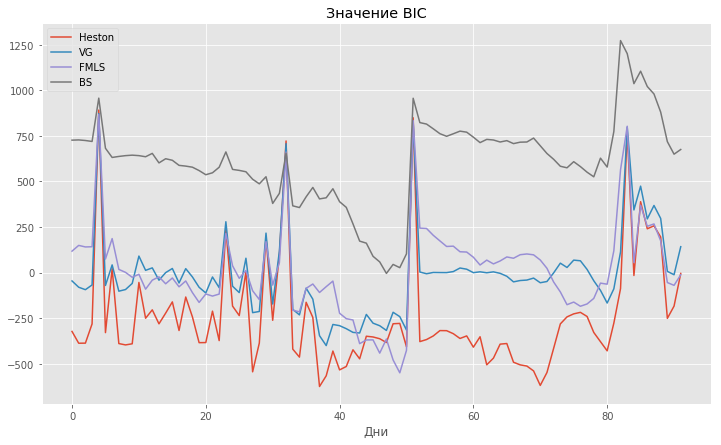

In [83]:
data, info = hf.read_new_data()
from_dir = "params/backup2017"
d = 91

# data, info = hf.read_data()
# from_dir = "params/backup"
# d = 187

def get_actual(day: int) -> np.ndarray:
    return np.append(data.prices[True][day], data.prices[False][day])

ax = pl.subplot(111)

for model in ['heston', 'vg', 'ls', 'bs']:
    params = hf.get_params(filename=hf.get_filename(model=model, metric=metric, from_dir=from_dir), model=model)
    bic_scores = []
    for day, pars in params.drop(columns=['score']).iterrows():
        market = EvalArgs.from_structure(data=data, info=info, day=day, rate=.008)
        pricer = GenPricer(model=model, market=market, use_fft=True)
        call_prices, put_prices = pricer.price(pars=pars.values)
        predicted = np.append(call_prices, put_prices)
        actual = get_actual(day)
        bic_scores.append(cmp.bic(k=len(pars.values), actual=actual, predicted=predicted))
    ax.plot(range(len(info)), bic_scores, label=hf.title(model))
ax.set_xlabel('Дни')
pl.title('Значение BIC')
pl.legend()
save_picture(f'BIC_{d}')

In [38]:
print(cmp.aic(2, np.arange(3), np.array([1, 2, 2])))
print(cmp.bic(2, np.arange(3), np.array([1, 2, 2])))

3.39180233784
1.58902691517


In [39]:
cmp = reload(cmp)

### Error distribution

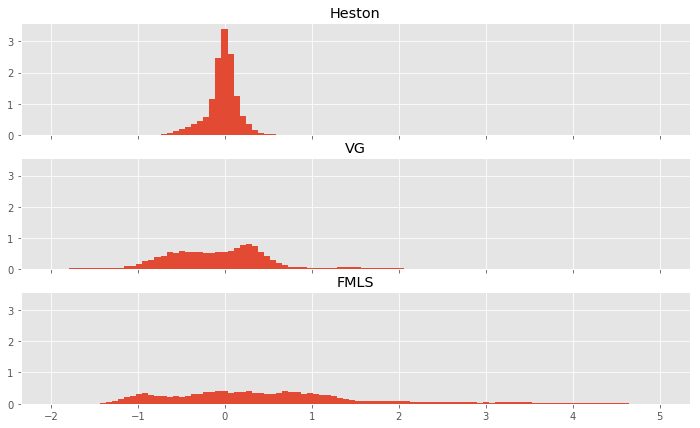

In [84]:
data, info = hf.read_data()
from_dir = 'params'

metric = 'RMSE'

i = 0
f, axarr = pl.subplots(3, 1, sharex='col', sharey='col')

for model in ['heston', 'vg', 'ls']:
    params = hf.get_params(filename=hf.get_filename(model=model, metric=metric, from_dir=from_dir), model=model).drop(columns=['score'])
    errors = np.array([])
    for day, pars in params.iterrows():
        pricer = GenPricer(model=model, market=EvalArgs.from_structure(data=data, info=info, day=day, rate=.008), use_fft=True)
        predicted = np.append(*pricer.price(pars=pars))
        actual = np.append(data.prices[True][day], data.prices[False][day])
        errors = np.append(errors, predicted - actual)
    axarr[i].hist(errors, bins=100, density=True, range=(-2, 5))
    axarr[i].set_title(hf.title(model))
    i += 1
save_picture(f'error_dist')

### volatility smirk

In [104]:
import black_scholes as bs
from tqdm import tqdm_notebook

bs = reload(bs)

HBox(children=(IntProgress(value=0, max=187), HTML(value='')))

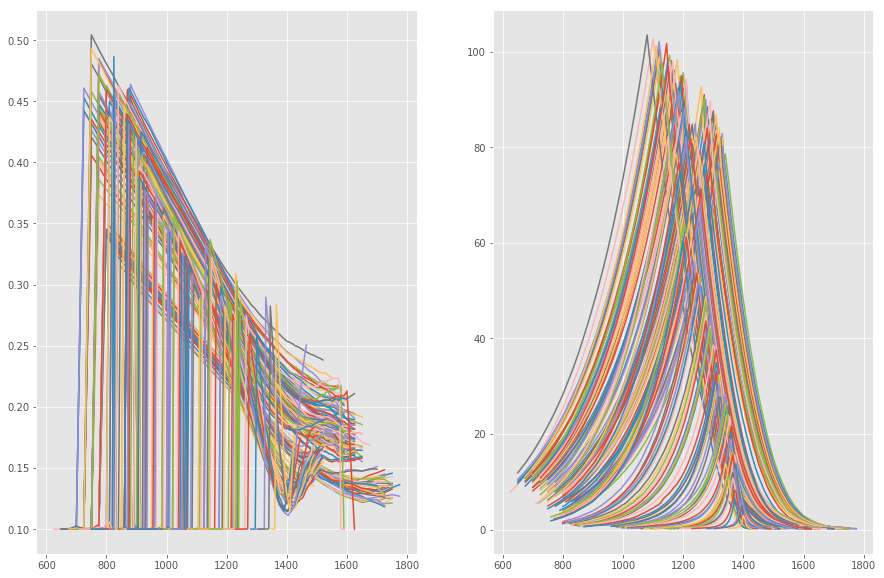

In [133]:
data, info = hf.read_data()
data, info = dh.remove_options(data=data, info=info, rate=.008, remove_itm=True)

f, axarr = pl.subplots(nrows=1, ncols=2, sharex='row')

for day in tqdm_notebook(range(len(info))):
    strikes_put = data.strikes[False][day]
    strikes_call = data.strikes[True][day]
    prices_put = data.prices[False][day]
    prices_call = data.prices[True][day]
    results = []
    for i in range(len(strikes_put)):
        results.append(bs.implied_sigma(spot=info[day].spot, strike=strikes_put[i], t=info[day].mat, r=.008, q=.008, is_call=False, price=prices_put[i]))
    for i in range(len(strikes_call)):
        results.append(bs.implied_sigma(spot=info[day].spot, strike=strikes_call[i], t=info[day].mat, r=.008, q=.008, is_call=True, price=prices_call[i]))
    all_strikes = np.append(strikes_put, strikes_call)
    all_prices = np.append(prices_put, prices_call)
    axarr[0].plot(all_strikes, list(map(lambda res: res.x[0], results)))
    axarr[1].plot(all_strikes, all_prices)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

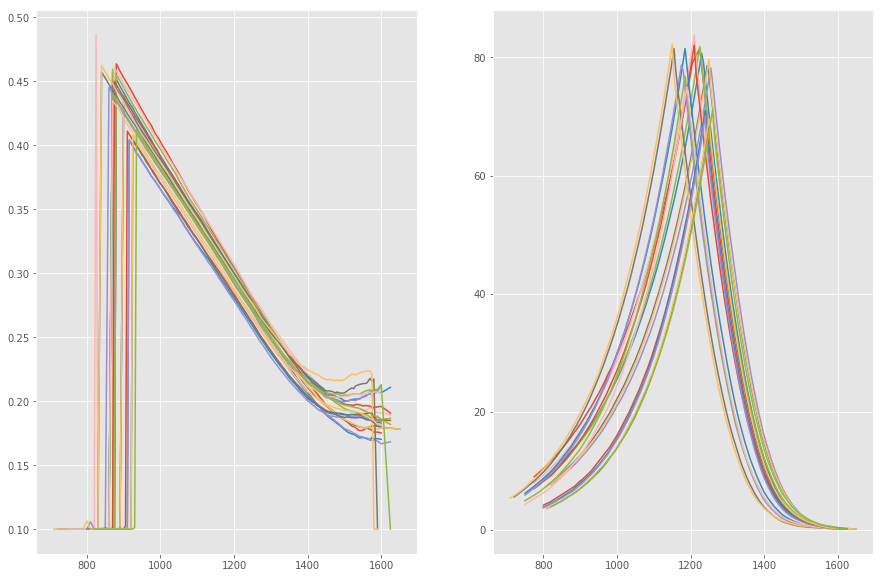

In [132]:
data, info = hf.read_data()
data, info = dh.remove_options(data=data, info=info, rate=.008, remove_itm=True)

f, axarr = pl.subplots(nrows=1, ncols=2, sharex='row')

start = 100
interval = 20

for day in tqdm_notebook(range(start, min(start + interval, len(info)))):
    strikes_put = data.strikes[False][day]
    strikes_call = data.strikes[True][day]
    prices_put = data.prices[False][day]
    prices_call = data.prices[True][day]
    results = []
    for i in range(len(strikes_put)):
        results.append(bs.implied_sigma(spot=info[day].spot, strike=strikes_put[i], t=info[day].mat, r=.008, q=.008, is_call=False, price=prices_put[i]))
    for i in range(len(strikes_call)):
        results.append(bs.implied_sigma(spot=info[day].spot, strike=strikes_call[i], t=info[day].mat, r=.008, q=.008, is_call=True, price=prices_call[i]))
    all_strikes = np.append(strikes_put, strikes_call)
    all_prices = np.append(prices_put, prices_call)
    axarr[0].plot(all_strikes, list(map(lambda res: res.x[0], results)))
    axarr[1].plot(all_strikes, all_prices)

In [112]:
strikes_call

array([ 1025.,  1030.,  1040.,  1050.,  1060.,  1070.,  1075.,  1080.,
        1090.,  1100.,  1110.,  1120.,  1125.,  1130.,  1140.,  1150.,
        1160.,  1170.,  1175.,  1180.,  1190.,  1200.,  1210.,  1220.,
        1225.,  1230.,  1240.,  1250.,  1260.,  1270.,  1275.,  1280.])

In [113]:
strikes_put

array([ 1290.,  1300.,  1310.,  1320.,  1325.,  1330.,  1340.,  1350.,
        1360.,  1370.,  1375.,  1380.,  1390.,  1400.,  1410.,  1420.,
        1425.,  1430.,  1440.,  1450.,  1460.,  1470.,  1475.,  1480.,
        1490.,  1500.,  1510.,  1520.,  1525.,  1530.])

In [128]:
dh = reload(dh)

### predict params

In [34]:
import warnings
warnings.filterwarnings("ignore", message='numpy.dtype size changed')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings('ignore', message="can't resolve package from __spec__ or __package__, ")

del sys.modules['sklearn.__check_build']

In [35]:
import sklearn.linear_model as lm 

ImportError: cannot import name 'murmurhash3_32'